In [9]:
import jax
import jax.numpy as jnp
from typing import Callable, Tuple
import logging
from NN import create_nn
from optim import create_cbo
import numpy as np
from gen_config import generate_configure

In [10]:
dim = 4
config  = generate_configure(dim)


In [11]:
init, apply = create_nn(1,**config["NN"])
config["sde"]["N_step"] = 500
config["sde"]["N_sample"] = 2000

params_old = init(jax.random.PRNGKey(0))
params= np.load(f"./result_{dim}/params.npy", allow_pickle=True)
params_new = []
for params_i in params:
    for key in params_i.keys():
        params_i[key] = params_i[key][0,0:1,...]
    params_new.append(params_i)

In [12]:
x_save = []
x_start  = config["sde"]["x_start"]
N_sample = config["sde"]["N_sample"]
T0 = config["sde"]["T0"]
T1 = config["sde"]["T1"]
N_step = config["sde"]["N_step"]
fcn_f = config["sde"]["fcn_f"]
fcn_g = config["sde"]["fcn_g"]
rng = jax.random.PRNGKey(200)
x = x_start[None, ...]+ 0.1*jax.random.normal(rng, shape=(N_sample,dim))
t = jnp.linspace(T0, T1, N_step+1).reshape(-1, 1)
dt = t[1] - t[0]
loss = jnp.zeros(N_sample)
x_save.append(x)    
for i in range(N_step):
    rng, key = jax.random.split(rng)
    t_current = t[i][None, ...].repeat(N_sample, axis=0)
    m = apply(params, jnp.concatenate([x, t_current], axis=-1))[:,0,0,0,0,:]
    x = x + 10 * dt * m + 0.1*jnp.sqrt(dt) * jax.random.normal(rng, shape=(N_sample, dim))
    x_save.append(x)    

In [13]:
N_step

500

In [14]:
x_save = jnp.stack(x_save, axis=0)

In [15]:
x_save.shape

(501, 2000, 4)

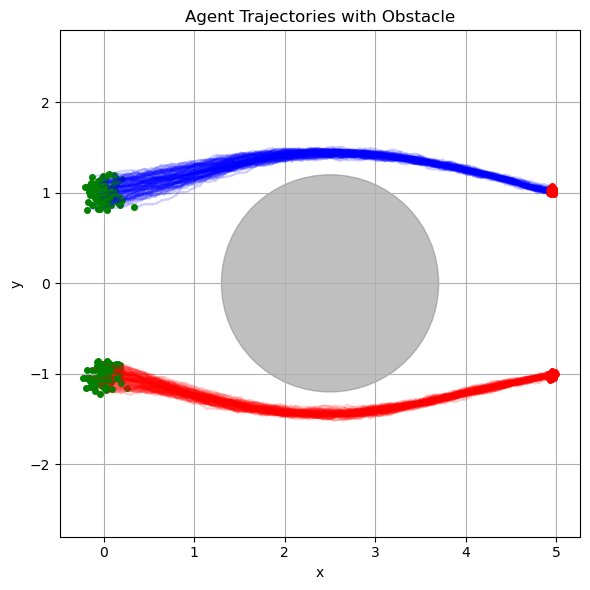

In [16]:
import matplotlib.pyplot as plt

num_samples = x_save.shape[1]

plt.figure(figsize=(6, 6))
for i in range(100):
    x = x_save[:, i, 0]  # x positions
    y = x_save[:, i, 1]  # y positions
    plt.plot(x, y, color='blue', alpha=0.2)  # faded lines for sample trajs
    plt.plot(x[0], y[0], 'go', markersize=4)  # start point
    plt.plot(x[-1], y[-1], 'ro', markersize=4)  # end point

    x = x_save[:, i, 2]  # x positions
    y = x_save[:, i, 3]  # y positions
    plt.plot(x, y, color='red', alpha=0.2)  # faded lines for sample trajs
    plt.plot(x[0], y[0], 'go', markersize=4)  # start point
    plt.plot(x[-1], y[-1], 'ro', markersize=4)  # end point
# Optional: Add obstacle
circle = plt.Circle((2.5, 0), 1.2, color='gray', alpha=0.5)  # example at (0,0)
plt.gca().add_patch(circle)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Agent Trajectories with Obstacle')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()